In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Dataset Loading

In [101]:
df = pd.read_csv("diabetes.csv")

Replace zero values with NaN in specific columns

In [102]:
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)

Impute missing values using mean

In [104]:
imputer = SimpleImputer(strategy='mean')
df[cols_to_fix] = imputer.fit_transform(df[cols_to_fix])

Exploratory Data Analysis (EDA)

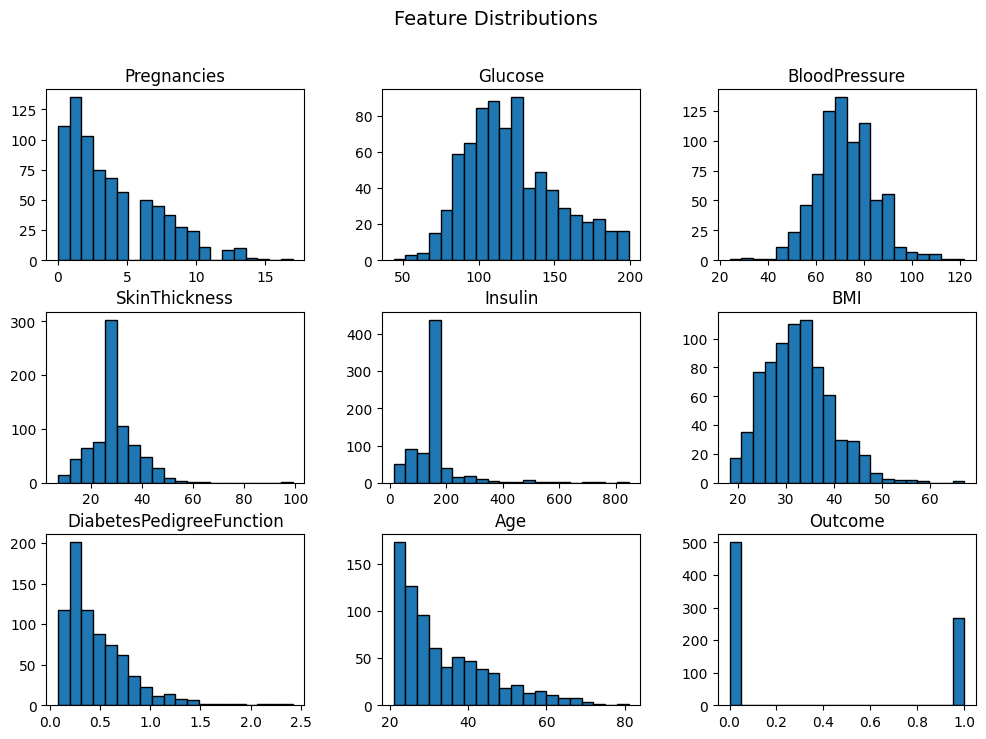

In [105]:
df.hist(bins=20, edgecolor='black', grid=False, figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

Boxplot for Outlier Detection

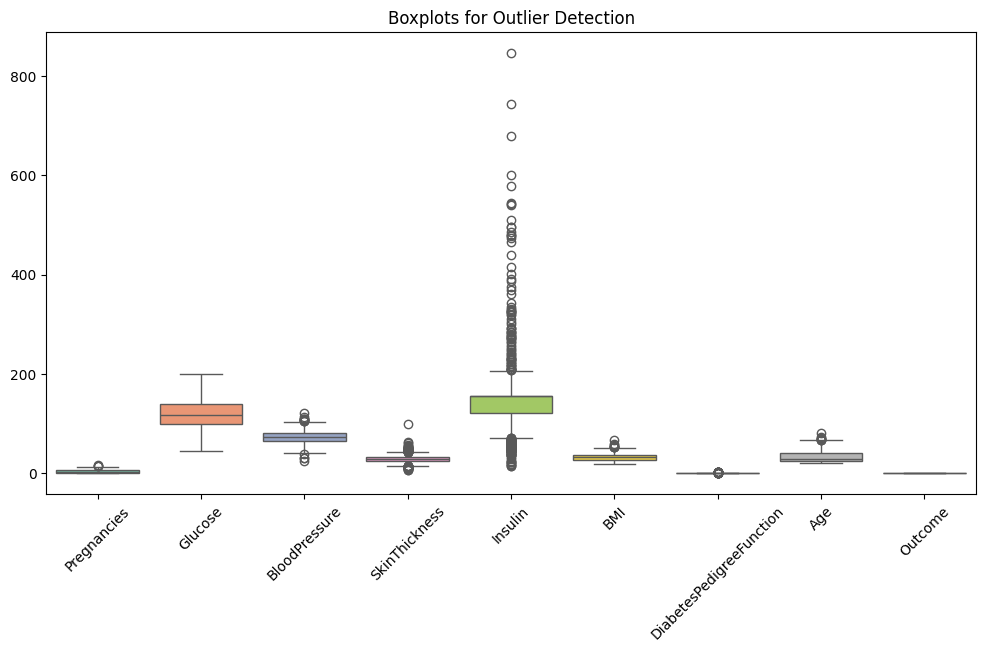

In [106]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplots for Outlier Detection")
plt.show()

Correlation Matrix Heatmap

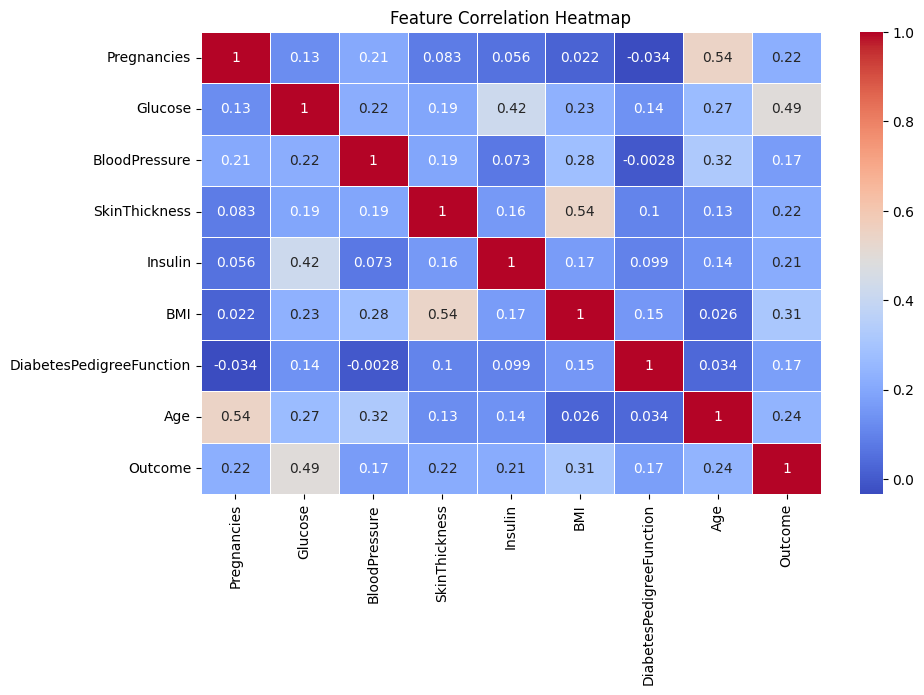

In [107]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Feature Engineering - Polynomial Features


In [109]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df.drop(columns=['Outcome']))

selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X_poly, df['Outcome'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)



Train-Test Split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['Outcome'], test_size=0.2, stratify=df['Outcome'], random_state=42)

Apply SMOTE

In [111]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Train and Evaluate Multiple Models

In [112]:
models = {
    "Support Vector Machine (SVM)": SVC(kernel="rbf", C=1, gamma="scale", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5)
}

for name, model in models.items():
    print(f"🔹 Training {name}...")
    
    model.fit(X_train_smote, y_train_smote)

    y_pred = model.predict(X_test)

    print(f"🔹 {name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))  # ✅ FIXED
    print("=" * 50)


🔹 Training Support Vector Machine (SVM)...
🔹 Support Vector Machine (SVM) Performance:
Accuracy: 0.7272727272727273
Confusion Matrix:
 [[70 30]
 [12 42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77       100
           1       0.58      0.78      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.73       154

🔹 Training Logistic Regression...
🔹 Logistic Regression Performance:
Accuracy: 0.6948051948051948
Confusion Matrix:
 [[71 29]
 [18 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       100
           1       0.55      0.67      0.61        54

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.69      0.70       154

🔹 Traini

Hyperparameter Tuning for Multiple Models

In [113]:
param_grids = {
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]},
    "Support Vector Machine": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Logistic Regression": {"C": [0.1, 1, 10], "max_iter": [500, 1000]}
}

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Tuning hyperparameters for K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}
Tuning hyperparameters for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}
Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 500}


Train and Evaluate Optimized Models

In [114]:
for name, model in best_models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_rep)


Model: Random Forest
Accuracy: 0.7662
Confusion Matrix:
 [[79 21]
 [15 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       100
           1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154


Model: K-Nearest Neighbors
Accuracy: 0.7208
Confusion Matrix:
 [[72 28]
 [15 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77       100
           1       0.58      0.72      0.64        54

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154


Model: Support Vector Machine
Accuracy: 0.7338
Confusion Matrix:
 [[73 27]
 [14 40]]
Classification Report:
               precision    r